In [1]:
from __future__ import unicode_literals
from bs4 import BeautifulSoup, SoupStrainer
import requests
import youtube_dl
import subprocess
import glob
import os
from pydub import AudioSegment
import pydub
import random
import librosa
import pickle as pkl
import python_speech_features
import numpy as np
from matplotlib import pyplot as plt

In [2]:
base_dir = "../../ttemp/TamperingDetection"

### Change bit rate

In [3]:
# for file in glob.glob("{}/mp3/320kbps/*".format(base_dir)):
#     audio = AudioSegment.from_file(file)
#     for rate in [96, 128, 160, 192, 256]:
#         audio.export("{}/mp3/{}kbps/{}".format(base_dir, rate, os.path.basename(file)), bitrate='{}k'.format(rate), format='mp3')

### Create N (No Edit) files by converting to wav

In [4]:
# for rate in [96, 128, 160, 192, 256, 320]:
#     for file in glob.glob("{}/mp3/{}kbps/*".format(base_dir, rate)):
#         sound = AudioSegment.from_file(file)
#         raw_name = os.path.basename(file).split('.')[0]
#         output_name = "{}/wav/{}kbps/".format(base_dir, rate) + raw_name
#         os.makedirs(os.path.dirname(output_name), exist_ok=True)
#         sound.export(output_name + '.wav', format="wav", parameters=["-ac", "1", "-ar", "16000"])

### Generate random numbers
Pick 10 10-sec segments for each audio and each type (i, d, r)

10 * 50 * 3 = 1500. Record only the start time in seconds. Store in a dictionary with queryid as keys.

Example: d['12_2_17_320_i1'] = [2.0].

Use the same segment for different bitrates.

In [5]:
bitrateKBPS = 160

In [23]:
seg_10_start = {}
random.seed(1234)
for file in glob.glob("{}/speech/source/wav/{}kbps/*".format(base_dir,bitrateKBPS)):

    query_id = os.path.basename(file).split('.')[0]
    length = librosa.get_duration(filename=file)
    end = int(length * 1000) - 10000
    for edit_type in ['n', 'i', 'r', 'd']:
        for i in range(1, 11):
            seg_10_start[query_id + "_{}{}".format(edit_type, i)] = random.randint(0, end) / 1000

In [8]:
time = 2
ins_pos = {}
ins_2_start = {}
from_file = {}
del_2_start = {}
rep_2_1_start = {} # replacing
rep_2_2_start = {} # replaced
random.seed(1)
files = glob.glob("{}/speech/source/wav/{}kbps/*".format(base_dir, bitrateKBPS))
for j, file in enumerate(files):
    query_id = os.path.basename(file).split('.')[0]
    for i in range(1, 11):
        length = librosa.get_duration(filename=file)
        end = int(length * 1000)
        from_file[query_id + "_{}".format(i)] = files[j-1] if j != 0 else files[-1]
        from_file_length = librosa.get_duration(filename=from_file[query_id + "_{}".format(i)])
        from_file_end = int(from_file_length * 1000)
        
        ins_pos[query_id + "_i{}".format(i)] = random.randint(0, 10000) / 1000
        ins_2_start[query_id + "_i{}".format(i)] = random.randint(0, from_file_end-time*1000) / 1000
        del_2_start[query_id + "_d{}".format(i)] = random.randint(0, 10000-time*1000) / 1000
        rep_2_1_start[query_id + "_r{}".format(i)] = random.randint(0, from_file_end-time*1000) / 1000
        rep_2_2_start[query_id + "_r{}".format(i)] = random.randint(0, 10000-time*1000) / 1000

### Generate queries

In [9]:
sr = 22050

In [10]:
# no edit
for file in glob.glob("{}/speech/source/wav/{}kbps/*".format(base_dir, bitrateKBPS)):
    print(file)
    query_id = os.path.basename(file).split('.')[0]
    orig_sound = AudioSegment.from_file(file)
    for i in range(1, 11):
        start_10 = seg_10_start[query_id + "_n{}".format(i)]
        edited_sound = orig_sound[start_10 * 1000 : (start_10 + 10) * 1000]
        output = "{}/speech/queries/160kbps/{}sec/{}_n{}_{}.wav".format(base_dir, time, query_id, i, bitrateKBPS)
        edited_sound.export(output, format="wav", parameters=["-ac", "1", "-ar", str(sr)])

../../ttemp/TamperingDetection/speech/source/wav/160kbps/12_9_17.wav
../../ttemp/TamperingDetection/speech/source/wav/160kbps/4_7_17.wav
../../ttemp/TamperingDetection/speech/source/wav/160kbps/12_30_17.wav
../../ttemp/TamperingDetection/speech/source/wav/160kbps/11_23_17.wav
../../ttemp/TamperingDetection/speech/source/wav/160kbps/9_29_17.wav
../../ttemp/TamperingDetection/speech/source/wav/160kbps/5_12_17.wav
../../ttemp/TamperingDetection/speech/source/wav/160kbps/3_30_18.wav
../../ttemp/TamperingDetection/speech/source/wav/160kbps/2_10_17.wav
../../ttemp/TamperingDetection/speech/source/wav/160kbps/6_9_17.wav
../../ttemp/TamperingDetection/speech/source/wav/160kbps/9_1_17.wav
../../ttemp/TamperingDetection/speech/source/wav/160kbps/3_3_17.wav
../../ttemp/TamperingDetection/speech/source/wav/160kbps/6_2_17.wav
../../ttemp/TamperingDetection/speech/source/wav/160kbps/5_13_18.wav
../../ttemp/TamperingDetection/speech/source/wav/160kbps/3_31_17.wav
../../ttemp/TamperingDetection/speech

In [11]:
# Insertion
for file in glob.glob("{}/speech/source/wav/{}kbps/*".format(base_dir,bitrateKBPS)):
    query_id = os.path.basename(file).split('.')[0]
    orig_sound = AudioSegment.from_file(file)
    for i in range(1, 11):
        ins_from_sound = AudioSegment.from_file(from_file[query_id + "_{}".format(i)])
        start_10 = seg_10_start[query_id + "_i{}".format(i)]
        start_2 = ins_2_start[query_id + "_i{}".format(i)]
        pos = ins_pos[query_id + "_i{}".format(i)]
        cropped_sound = orig_sound[start_10 * 1000 : (start_10 + 10) * 1000]
        edited_sound = cropped_sound[: pos * 1000] \
                + ins_from_sound[start_2 * 1000 : (start_2 + time) * 1000] \
                + cropped_sound[pos * 1000 :] 
        output = "{}/speech/queries/160kbps/{}sec/{}_i{}_{}.wav".format(base_dir, time, query_id, i, bitrateKBPS)
        edited_sound.export(output, format="wav", parameters=["-ac", "1", "-ar", str(sr)])

In [91]:
# Deletion
for file in glob.glob("{}/speech/source/wav/{}kbps/*".format(base_dir, bitrateKBPS)):
    print(file)
    query_id = os.path.basename(file).split('.')[0]
    orig_sound = AudioSegment.from_file(file)
    for i in range(1, 11):
        start_10 = seg_10_start[query_id + "_d{}".format(i)]
        start_2 = del_2_start[query_id + "_d{}".format(i)]
        cropped_sound = orig_sound[start_10 * 1000 : (start_10 + 10) * 1000]
        edited_sound = cropped_sound[: start_2 * 1000] + cropped_sound[(start_2 + time) * 1000 :] 
        output = "{}/speech/queries/160kbps/{}sec/{}_d{}_{}.wav".format(base_dir, time, query_id, i, bitrateKBPS)
        edited_sound.export(output, format="wav", parameters=["-ac", "1", "-ar", str(sr)])

../../ttemp/TamperingDetection/speech/source/wav/160kbps/12_9_17.wav
../../ttemp/TamperingDetection/speech/source/wav/160kbps/4_7_17.wav
../../ttemp/TamperingDetection/speech/source/wav/160kbps/12_30_17.wav
../../ttemp/TamperingDetection/speech/source/wav/160kbps/11_23_17.wav
../../ttemp/TamperingDetection/speech/source/wav/160kbps/9_29_17.wav
../../ttemp/TamperingDetection/speech/source/wav/160kbps/5_12_17.wav
../../ttemp/TamperingDetection/speech/source/wav/160kbps/3_30_18.wav
../../ttemp/TamperingDetection/speech/source/wav/160kbps/2_10_17.wav
../../ttemp/TamperingDetection/speech/source/wav/160kbps/6_9_17.wav
../../ttemp/TamperingDetection/speech/source/wav/160kbps/9_1_17.wav
../../ttemp/TamperingDetection/speech/source/wav/160kbps/3_3_17.wav
../../ttemp/TamperingDetection/speech/source/wav/160kbps/6_2_17.wav
../../ttemp/TamperingDetection/speech/source/wav/160kbps/5_13_18.wav
../../ttemp/TamperingDetection/speech/source/wav/160kbps/3_31_17.wav
../../ttemp/TamperingDetection/speech

In [13]:
# Replacement
for file in glob.glob("{}/speech/source/wav/{}kbps/*".format(base_dir, bitrateKBPS)):
    query_id = os.path.basename(file).split('.')[0]
    orig_sound = AudioSegment.from_file(file)
    for i in range(1, 11):
        rep_from_sound = AudioSegment.from_file(from_file[query_id + "_{}".format(i)])
        start_10 = seg_10_start[query_id + "_r{}".format(i)]
        start_1_2 = rep_2_1_start[query_id + "_r{}".format(i)] # replacing
        start_2_2 = rep_2_2_start[query_id + "_r{}".format(i)] # replaced
        cropped_sound = orig_sound[start_10 * 1000 : (start_10 + 10) * 1000]
        edited_sound = cropped_sound[: start_2_2 * 1000] \
                + rep_from_sound[start_1_2 * 1000 : (start_1_2 + time) * 1000] \
                + cropped_sound[(start_2_2 + time) * 1000 :] 
        output = "{}/speech/queries/160kbps/{}sec/{}_r{}_{}.wav".format(base_dir, time, query_id, i, bitrateKBPS)
        edited_sound.export(output, format="wav", parameters=["-ac", "1", "-ar", str(sr)])

In [21]:
seg_10_start

{'12_9_17_n1': 115.535,
 '12_9_17_n2': 30.631,
 '12_9_17_n3': 1.963,
 '12_9_17_n4': 23.761,
 '12_9_17_n5': 9.155,
 '12_9_17_n6': 22.003,
 '12_9_17_n7': 25.8,
 '12_9_17_n8': 92.965,
 '12_9_17_n9': 62.078,
 '12_9_17_n10': 4.568,
 '12_9_17_i1': 8.077,
 '12_9_17_i2': 4.152,
 '12_9_17_i3': 90.725,
 '12_9_17_i4': 126.942,
 '12_9_17_i5': 121.516,
 '12_9_17_i6': 38.942,
 '12_9_17_i7': 23.93,
 '12_9_17_i8': 47.996,
 '12_9_17_i9': 29.992,
 '12_9_17_i10': 3.832,
 '12_9_17_r1': 131.88,
 '12_9_17_r2': 127.598,
 '12_9_17_r3': 65.49,
 '12_9_17_r4': 16.924,
 '12_9_17_r5': 141.843,
 '12_9_17_r6': 122.132,
 '12_9_17_r7': 17.975,
 '12_9_17_r8': 23.312,
 '12_9_17_r9': 135.015,
 '12_9_17_r10': 12.049,
 '12_9_17_d1': 70.67,
 '12_9_17_d2': 145.865,
 '12_9_17_d3': 16.535,
 '12_9_17_d4': 79.279,
 '12_9_17_d5': 126.1,
 '12_9_17_d6': 93.123,
 '12_9_17_d7': 69.849,
 '12_9_17_d8': 65.313,
 '12_9_17_d9': 52.437,
 '12_9_17_d10': 118.852,
 '4_7_17_n1': 138.978,
 '4_7_17_n2': 174.433,
 '4_7_17_n3': 5.059,
 '4_7_17_n4'

### Generate annotation

In [14]:
with open('{}/annots/{}kbps_{}sec.gt'.format(base_dir,bitrateKBPS,time), 'w') as f:
    # insertion
    for query in sorted(ins_pos.keys()):
        query_10 = query.replace("_160_", "_")
        queryid = query[0:query.rfind('_')]
        tstart_base = seg_10_start[query_10]
        tend_base = tstart_base + 10
        istart_relative = ins_pos[query]
        ins_from_file = from_file[query.replace("i", "")].split('/')[-1].split('.')[0]
        ins_start = ins_2_start[query]
        ins_end = ins_2_start[query] + time
        message = "I {} {} {} {} {} {} {}".format("{}_{}".format(query, bitrateKBPS), queryid, tstart_base, tend_base, istart_relative, ins_from_file, ins_start, ins_end)
        f.write(message)
        f.write('\n')

    # deletion
    for query in sorted(del_2_start.keys()):
        query_10 = query.replace("_160_", "_")
        queryid = query[0:query.rfind('_')]
        tstart_base = seg_10_start[query_10]
        tend_base = tstart_base + 10
        dstart_relative = del_2_start[query]
        dend_relative = del_2_start[query] + time
        message = "D {} {} {} {} {}".format("{}_{}".format(query, bitrateKBPS), queryid, tstart_base, tend_base, dstart_relative, dend_relative)
        f.write(message)
        f.write('\n')

    # replacement
    for query in sorted(rep_2_1_start.keys()):
        query_10 = query.replace("_160_", "_")
        queryid = query[0:query.rfind('_')]
        tstart_base = seg_10_start[query_10]
        tend_base = tstart_base + 10
        rstart_relative = rep_2_2_start[query]
        rend_relative = rep_2_2_start[query] + time
        rcut_start = rep_2_1_start[query]
        rcut_end = rep_2_1_start[query] + time
        rep_from_file = from_file[query.replace("r", "")].split('/')[-1].split('.')[0]
        message = "R {} {} {} {} {} {} {} {}".format("{}_{}".format(query, bitrateKBPS), queryid, tstart_base, tend_base, rstart_relative, rend_relative, rep_from_file, rcut_start, rcut_end)
        f.write(message)
        f.write('\n')
        
    # no edit
    for query in sorted(rep_2_1_start.keys()):
        query_10 = query.replace("_160_", "_")
        query_10 = query_10.replace("r", "n")
        queryid = query[0:query.rfind('_')]
        tstart_base = seg_10_start[query_10]
        query = query.replace('r', 'n')
        tend_base = tstart_base + 10
        message = "N {} {} {}".format("{}_{}".format(query, bitrateKBPS), queryid, tstart_base, tend_base)
        f.write(message)
        f.write('\n')

### Generate configuration files (Skipped)

In [16]:
allIDS = []

with open('{}/cfg_files/all.ids'.format(base_dir), 'w') as f:
    for query in sorted(ins_pos.keys()):
        if query[-1] == '1':
            queryFile = query[0:query.rfind('_')]
            f.write(queryFile)
            allIDS.append(queryFile)
            f.write('\n')

In [94]:
with open('{}/cfg_files/train.ids'.format(base_dir), 'r') as ids:
    allTrainIDS = ids.read().split('\n')
ids.close()

In [18]:
with open('{}/cfg_files/test.ids'.format(base_dir), 'w') as f:
    for query in (allIDS):
        if(query not in allTrainIDS):
            f.write(query)
            f.write('\n')
f.close()

In [19]:
def createPairsFile(IDSFile, timeSec):
    with open('{}/cfg_files/{}'.format(base_dir, IDSFile), 'r') as ids:
        pairsFile = IDSFile.split('.')[0] + '_{}s.pairs'.format(timeSec)
        with open('{}/cfg_files/{}'.format(base_dir, pairsFile), 'w') as pairs:
            for queryid in ids.read().split('\n'):
                if queryid == "":
                    continue
                for piece in range(1, 11):
                    for edit_type in ['n', 'i', 'r', 'd']:
                        pairs.write("{}/speech/queries/{}kbps/{}sec/{}_{}{}_{}.wav ".format(base_dir, bitrateKBPS, timeSec,queryid, edit_type, piece, bitrateKBPS))
                        pairs.write("{}/speech/ref/{}.wav ".format(base_dir, i))
                        pairs.write('\n')

In [20]:
createPairsFile('train.ids', 2)
createPairsFile('test.ids', 1)
createPairsFile('test.ids', 2)
createPairsFile('test.ids', 3)
createPairsFile('test.ids', 4)

### MFCC

In [4]:
n_mfcc = 12
n_mels = 40
n_fft = 512 
hop_length = 512
fmin = 0
fmax = None
#sr = 16000

In [21]:
def getMFCC(query_id, piece_type='reference', edit_type='n1', save=False):
    n_mfcc = 13
    n_mels = 40
    n_fft = 512 
    hop_length = 512
    fmin = 0
    fmax = None
    sr = 22050
    if piece_type =='reference':
        file_dir = '../ttemp/TamperingDetection/data/audio/reference/{}.wav'.format(query_id.replace("_160", ""))
        out_dir = '../ttemp/TamperingDetection/data/mfcc/reference/{}.pkl'.format(query_id.replace("_160", ""))
    else:
        file_dir = '../ttemp/TamperingDetection/data/audio/queries/160kbps/2sec/{}_{}.wav'.format(query_id, edit_type)
        out_dir = '../ttemp/TamperingDetection/data/mfcc/queries/160kbps/2sec/{}_{}.pkl'.format(query_id, edit_type)
    
    y, sr = librosa.load(file_dir, sr=None)
    mfcc_librosa = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=12)
    mfcc_speech = python_speech_features.mfcc(signal=y, samplerate=sr, winlen=n_fft / sr, winstep=hop_length / sr,
                                          numcep=n_mfcc, nfilt=n_mels, nfft=n_fft, lowfreq=fmin, highfreq=fmax,
                                          preemph=0.0, ceplifter=0, appendEnergy=False)
    delta_mfcc = python_speech_features.delta(mfcc_speech, 2)
    delta_delta_mfcc = python_speech_features.delta(mfcc_speech, 3)
    mfcc_new = np.hstack((np.hstack((mfcc_speech, delta_mfcc)),delta_delta_mfcc))
    
    if save:
        with open(out_dir, 'wb') as f:
            d = {}
            d['old'] = mfcc_librosa
            d['new'] = mfcc_new
            pkl.dump(d, f)
    else:
        return mfcc_librosa, mfcc_speech

In [22]:
mfcc_librosa, mfcc_speech = getMFCC('10_6_17', piece_type='queries', edit_type='i1', save=False)

In [23]:
mfcc_librosa.shape

(12, 376)

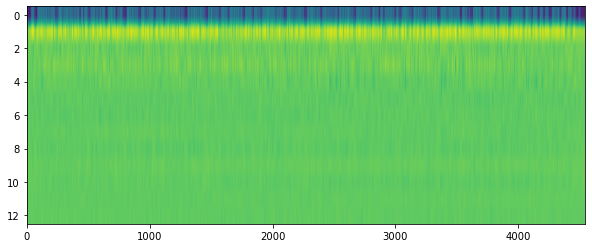

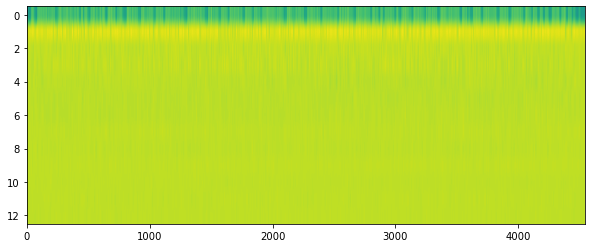

In [123]:
plt.figure(figsize=(10, 4))
plt.imshow(mfcc_librosa, aspect='auto')
plt.show()
plt.figure(figsize=(10, 4))
plt.imshow(mfcc_new.T, aspect='auto')
plt.show()

In [146]:
with open ('/home/mshan/ttemp/TamperingDetection/data/cfg_files/all.ids', 'r') as f:
    for query_id in f.read().split('\n'):
        print("Processing {}...".format(query_id))
        for edit_type in ['n', 'i', 'r', 'd']:
            for piece in range(1, 11):
                getMFCC(query_id, piece_type='queries', edit_type=edit_type+str(piece), save=True)

Processing 10_6_17...
Processing 11_23_17...
Processing 12_16_17...
Processing 12_2_17...
Processing 12_30_17...
Processing 12_9_17...
Processing 1_15_18...
Processing 2_10_17...
Processing 2_10_18...
Processing 2_17_17...
Processing 2_25_17...
Processing 3_10_17...
Processing 3_10_18...
Processing 3_18_17...
Processing 3_25_17...
Processing 3_30_18...
Processing 3_31_17...
Processing 3_31_18...
Processing 3_3_17...
Processing 4_13_18...
Processing 4_14_17...
Processing 4_21_17...
Processing 4_27_18...
Processing 4_28_17...
Processing 4_7_17...
Processing 4_7_18...
Processing 5_12_17...
Processing 5_13_18...
Processing 5_19_17...
Processing 5_26_17...
Processing 5_5_17...
Processing 6_16_17...
Processing 6_16_18...
Processing 6_23_17...
Processing 6_23_18...
Processing 6_2_17...
Processing 6_2_18...
Processing 6_30_17...
Processing 6_9_17...
Processing 7_14_17...
Processing 7_21_17...
Processing 7_28_17...
Processing 7_7_17...
Processing 8_25_17...
Processing 8_4_17...
Processing 9_15_